[ML with Python] 4. 특성 자동 선택
- 본 포스팅은 특성 자동 선택에 관한 기본적인 내용에 관하여 다룹니다.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1)-Introduction" data-toc-modified-id="1)-Introduction-1">1) Introduction</a></span></li><li><span><a href="#2)-일변량-통계-(-SelectPercentile-/-SelectKBest-&amp;-f_classif-/-f_regression-)" data-toc-modified-id="2)-일변량-통계-(-SelectPercentile-/-SelectKBest-&amp;-f_classif-/-f_regression-)-2">2) 일변량 통계 ( SelectPercentile / SelectKBest &amp; f_classif / f_regression )</a></span></li><li><span><a href="#3)-모델-기반-특성-선택-(-SelectFromModel-)" data-toc-modified-id="3)-모델-기반-특성-선택-(-SelectFromModel-)-3">3) 모델 기반 특성 선택 ( SelectFromModel )</a></span></li><li><span><a href="#4)-반복적-특성-선택-(-RFE-)" data-toc-modified-id="4)-반복적-특성-선택-(-RFE-)-4">4) 반복적 특성 선택 ( RFE )</a></span></li><li><span><a href="#5)-References" data-toc-modified-id="5)-References-5">5) References</a></span></li></ul></div>

---

필요라이브러리 import

In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False 
plt.rc('font', family='Malgun Gothic') 

<br>

---

### 1) Introduction

새로운 특성을 만드는 방법들은 전에 확인 하였듯이, 원본 특성의 수 이상으로 데이터 차원이 증가하기 쉽다. 그러나 <u>특성이 추가</u>되면 <u>모델은 더 복잡해지고 과대적합될 가능성도 높아진다</u>. 따라서, 다음과 같은 경우

- 새로운 특성을 추가
- 고차원 데이터셋 사용

<u> 가장 유용한 특성만 선택하고 나머지는 무시해서 특성의 수를 줄이는 것이 좋다</u>. 이렇게하면 모델이 간단해지고 일반화 성능도 올라가게 된다. 

<br>

어떤 특성이 좋은지 알 수 있는 전략은 다음과 같이 존재한다.

- 일변량 통계(univariate statistics)
- 모델 기반 선택(model-based-selection)
- 반복적 선택(iterative selection)

이 방법들은 모두 `지도 학습 방법`이므로 최적값을 찾으려면 `타깃값`이 필수적이다. 그리고 데이터를 훈련 세트와 테스트 세트로 나눈 다음 `훈련 데이터`<u>만을 </u>`특성 선택`<u>에 사용해야 한다</u>(정보 누설을 막기 위해서).

<br>

---

### 2) 일변량 통계 ( SelectPercentile / SelectKBest & f_classif / f_regression )

- 개개의 `특성`과 `타깃` 사이에 중요한 `통계적 관계`가 있는지를 계산, 계산 후 깊게 관련되어 있다고 판단되는 특성을 선택
- `분류`에서는 `분산분석(ANOVA, analysis of variance)`라고 불림
- 핵심 키워드는 `일변량`, 즉 <u>각 특성이 독립적으로 평가</u>됨, 따라서 다른 특성과 깊게 연관된 특성은 선택되지 않는다.
- 장점
    - 계산이 매우 빠르며 평가를 위해 모델을 만들 필요가 없다.
    - 특성을 선택한 후 적용하려는 모델에 상관없이 사용 가능하다.
    
<br>

scikit-learn에서, `일변량 분석`으로 특성을 선택하려면...

- 분류 => `f_classif(기본값)`
- 회귀 => `f_regression`

위와 같이 타입별로 선택을 하고, 계산한 `p-value`에 기초하여 특성을 제외한다. 이때, `p-value`<u>가 높을수록 타깃과의 연관성이 떨어지는 것을 의미</u>하기 때문에 <u>p-value가 높은 특성을 제외</u>시키기 위하여 `임계값`<u>을 조정하는 매개변수</u>를 사용한다.

<br>

`임계값`을 계산하는 방법은 `SelectKBest`와 `SelectPercentile` 등이 있다.
- `SelectKBest` : 고정된 k개의 특성을 선택
- `SelectPercentile` : 지정된 비율 만큼 특성을 선택

<br>

그럼 cancer 데이터셋에 분류를 위한 `특성 선택`을 적용해보자. 문제를 좀 더 복잡하게 하기 위해 의미없는 노이즈 특성을 데이터에 추가할 것이다. `특성 선택`이 새로 생성된 의미없는 특성을 제대로 식별하는지에 주목하자.

In [159]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# 기존 cancer데이타의 특성은 30개였지만, noise 50개를 추가하여 특성이 총 80개가 된다.
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state = 0, test_size = .5)

#f_classif(기본값)와 SelectPercentile을 사용하여 특성의 50%를 선택한다.
select = SelectPercentile(score_func = f_classif, percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)

print("X_train.shape : ", X_train.shape)
print("X_train_selected.shape : ", X_train_selected.shape )

X_train.shape :  (284, 80)
X_train_selected.shape :  (284, 40)


결과 노이즈 포함 80개의 특성 중에서 40개까지 줄어든 것을 확인할 수 있다. 

<br>

여기서 `get_support()`메서드를 선택된 특성과 제외된 특성을 불린값으로 확인할 수 있다. 아래의 마스킹된 그래프에서 볼 수 있듯이 선택된 특성은 대부분 원본 특성(0 ~ 30번까지)이며, 노이즈(30 ~ 80번까지)는 대부분 제거된 것을 확인할 수가 있다. 하지만, 원본 특성이 완벽하게 추출된 것은 아니다.

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


([<matplotlib.axis.YTick at 0x1fa0f701ac8>], [Text(0, 0, '')])

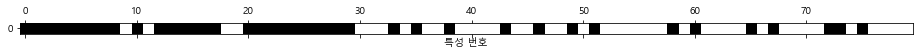

In [126]:
mask = select.get_support()

print(mask)

plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
plt.xlabel('특성 번호')
plt.yticks([0])

<br>

이렇게 선택된 특성들을 이용하면 모델의 성능 점수가 향상되겠지만, 실제 데이터에서의 결과는 보통 엇갈리는 경우도 많다. 하지만, 너무 많은 특성 때문에 모델을 만들기가 현실적으로 어려울 때 일변량 분석을 사용하여 특성을 선택하면 큰 도움이 될 수 있다 (~물론 타깃값이 있을 때 ㅋㅋ;;~).

<br>

---
### 3) 모델 기반 특성 선택 ( SelectFromModel )

- `지도 학습 머신러닝 모델`(아무거나 괜찮다.)을 사용하여 <u>특성의 중요도를 평가해서 가장 중요한 특성들만 선택</u>한다.
- `일변량 분석`과 반대로, <u>한 번에 모든 특성을 고려하기에 상호작용 부분을 반영</u>할 수 있다(물론 상호작용이 발견된다면).
- `SelectFromModel`에 구현되어 있다.
    - (지도 학습 모델로 계산된) 중요도가 지정한 임계치보다 큰 모든 특성을 선택

트리 100개로 만든 랜덤 포레스트 분류기를 사용해 특성 중요도를 계산해보자. 이는 매우 복잡한 모델이고 `일변량 분석`보다도 더 강력한 방법이다.

In [171]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# 일변량 분석으로 선택한 결과를 비교하기 위해 절반 가량의 특성이 선택될 수 있도록
# 중간값(median) 임계치를 사용한다.
# L1규제가 없는 경우 threshold 매개변수의 기본값은 평균값 mean이다.
# 또한, "1.2*median", "1.3*mean"처럼 중간값과 평균값의 비율로도 나타낼 수 있다.
select = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42), threshold='median')


select.fit(X_train,y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape : ", X_train.shape)
print("X_train_l1.shape : ", X_train_l1.shape)

X_train.shape :  (284, 80)
X_train_l1.shape :  (284, 40)


<br>

선택된 특성을 `일변량 분석`과 같은 방식으로 그려보았을 때, 원본 특성에서 두 개를 제외한 모든 원본 특성이 선택되어있는 것을 확인할 수 있다(`일변량 분석`보다 성능이 좋음). 특성을 40개 선택하도록 지정(threshold = 'median')했기 때문에 일부 노이즈 특성도 선택되었다.

([<matplotlib.axis.YTick at 0x1fa0f147e88>], [Text(0, 0, '')])

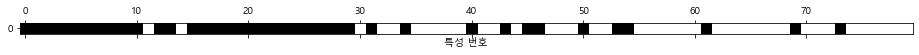

In [173]:
mask = select.get_support()

plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
plt.xlabel('특성 번호')
plt.yticks([0])

<br>

---

### 4) 반복적 특성 선택 ( RFE )

- 특성의 수가 각기 다른 (/) 일련의 모델이 (/) 만들어진다.
- How?
    - 방법1) 특성을 하나도 선택하지 않은 상태로 시작해서 어떤 종료 조건에 도달할 때 까지 하나씩 추가하는 방법
    - 방법2) 모든 특성을 가지고 시작해서 어떤 종료 조건에 도달할 때 까지 하나씩 제거하는 방법
    - `재귀적 특성 제거(RFE, recursive feature elimination)`(위의 방법들 중 하나)
        - 모든 특성으로 시작해서 모델을 만들고 특성 중요도가 가장 낮은 특성을 제거
        - 제거한 특성을 빼고 나머지 특성 전체로 새로운 모델을 생성
        - 미리 정의한 특성 개수가 남을 때까지 반복
    - <u>특성 선택에 사용할 모델은 특성의 중요도를 결정하는 방법을 제공해야한다</u>.
 
<br> 
 
앞서 사용한 랜덤 포레스트 모델을 예시로 사용하여 확인해 보았을 때, `일변량 분석`이나 `모델 기반 선택`보다 특성 선택이 나아진 것을 확인할 수 있다. 하지만, 여전히 특성 한개를 놓치는 것을 확인할 수 있다. 또한, 랜덤 포레스트 모델은 특성이 누락될 때마다 다시 학습하므로 40번이나 실행되어 다른 방법들보다 훨씬 오래 걸리는 것을 확인할 수 있다.

([<matplotlib.axis.YTick at 0x1fa109cb408>], [Text(0, 0, '')])

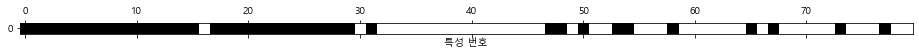

In [176]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators= 100, random_state=42), n_features_to_select=40)

select.fit(X_train, y_train)

# 선택된 특성 표시
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
plt.xlabel("특성 번호")
plt.yticks([0])

<br>

머신러닝 알고리즘에 어떤 입력값을 넣을지 확신이 없을 경우에 `특성 자동 선택`이 도움될 수 있다. 또 예측 속도를 높이거나 해석하기 더 쉬운 모델을 만드는 데 필요한 만큼 특성의 수를 줄이는데도 효과적이다. 하지만, 대부분 실전에서는 `특성 선택`이 큰 성능 향상을 끌어내지는 못한다고 한다. 그러나 `특성 선택`은 머신러닝 기술자에게 여전히 중요한 도구이다.

<br>

---

### 5) References

- 안드레아스 뮐러, 세라 가이도, 『파이썬 라이브러리를 활용한 머신러닝』, 박해선, 한빛미디어(2017)